In [136]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
#matplotlib.rc('text',usetex=True)
font = {'family' : 'serif',
#        'weight' : 'bold',
        'size'   : 16,}
matplotlib.rc('font', **font)

import os
import h5py


import numpy as np
import pandas as pd
import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
font = {'family' : 'serif',
#        'weight' : 'bold',
        'size'   : 16,}
matplotlib.rc('font', **font)

from astropy.io import fits
import os
import time
from tqdm import tqdm
import yaml
import scipy
from scipy.special import erf
import scipy.stats as stats
import scipy.signal as signal
from scipy.optimize import curve_fit,minimize
import h5py
from datetime import datetime,timedelta
import corner
import fitramp_rescaled as fitramp
import importlib

import fit_time_dep_fluxes as fit_flux
from importlib import reload
reload(fit_flux)




<module 'fit_time_dep_fluxes' from 'C:\\Users\\78738\\SDSS5\\data ---  time dependent\\fit_time_dep_fluxes.py'>

In [137]:
tele = 'apo'
ftype = 'object'

expid = "0029"
chip = "R"
mjd = 60992

# expid = "0065"
# chip = "R"
# mjd = 60781

# expid = "0041"
# chip = "R"
# mjd = 60786

datapath = './'

fname_1d = f'{datapath}ar1Dcal_{tele}_{mjd}_{expid}_{chip}_{ftype}.h5'
data_1d = h5py.File(fname_1d)
print(data_1d.keys())

fiber_types = np.array(data_1d['fiberTypeList']).astype(str)
fiber_flux_1ds = np.array(data_1d['flux_1d'])
fiber_med_fluxes = np.nanmedian(fiber_flux_1ds,axis=1)
fiber_trace_centers = np.array(data_1d['extract_trace_centers'])-1 #subtract 1 because indices are from Julia

data_1d.close()

<KeysViewHDF5 ['bitmsk_relthrpt', 'dropped_pixels_mask_1d', 'extract_trace_centers', 'fiberTypeList', 'flux_1d', 'ivar_1d', 'mask_1d', 'metadata', 'relthrpt', 'trace_used_param_fname']>


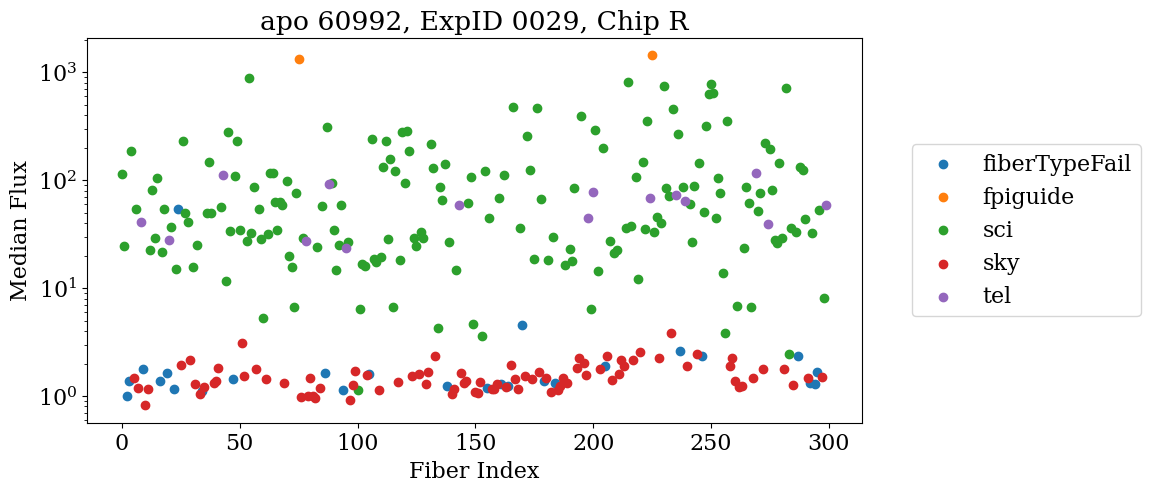

In [138]:
fiber_inds = np.arange(fiber_med_fluxes.shape[0])

unique_fiber_types = np.unique(fiber_types)

plt.figure(figsize=(10,5))
plt.title(f'{tele} {mjd}, ExpID {expid}, Chip {chip}')
for fib_type in unique_fiber_types:
    curr_keep = (fiber_types == fib_type)
    plt.scatter(fiber_inds[curr_keep],fiber_med_fluxes[curr_keep],label=fib_type)
plt.legend(loc=6,bbox_to_anchor=(1.05,0.5))
plt.gca().set_yscale('log')
plt.xlabel('Fiber Index')
plt.ylabel('Median Flux')
plt.show()

Current fiber index: 251
Current fiber type: sci
Current fiber median flux: 643.4


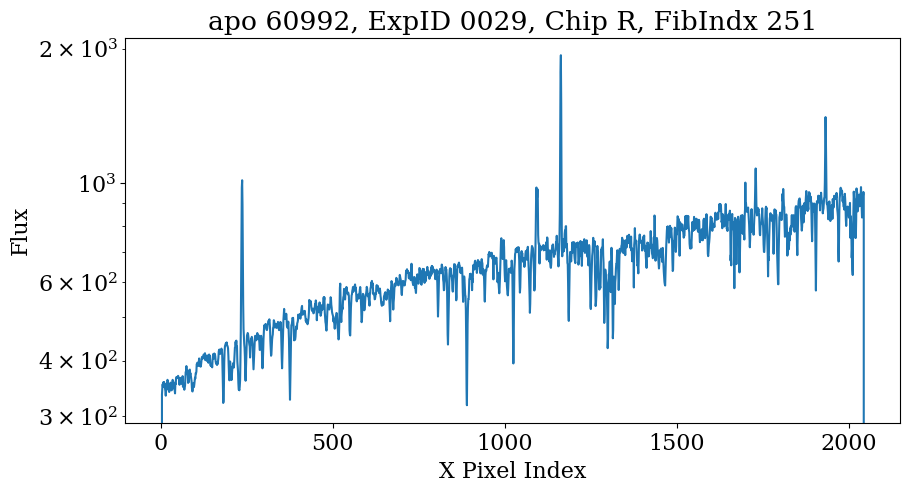

In [139]:
#sort the sci and tel fibers by median flux (decreasing from max)
use_types = ((fiber_types == 'sci') | (fiber_types == 'tel'))
#use_types = ((fiber_types == 'sky'))
good_explore_inds = np.where(use_types)[0][np.argsort(fiber_med_fluxes[use_types])[::-1]]
chosen_fib_ind = good_explore_inds[0]
chosen_fib_ind = good_explore_inds[5]

print(f'Current fiber index: {chosen_fib_ind}')
print(f'Current fiber type: {fiber_types[chosen_fib_ind]}')
print(f'Current fiber median flux: {round(fiber_med_fluxes[chosen_fib_ind],2)}')


x_inds = np.arange(fiber_flux_1ds.shape[1])
plt.figure(figsize=(10,5))
plt.gca().set_yscale('log')
plt.title(f'{tele} {mjd}, ExpID {expid}, Chip {chip}, FibIndx {chosen_fib_ind}')
plt.plot(x_inds,fiber_flux_1ds[chosen_fib_ind])
plt.xlabel('X Pixel Index')
plt.ylabel('Flux')
plt.show()


In [140]:
fname_3d = f'{datapath}ar3Dcal_{tele}_{mjd}_{expid}_{chip}_{ftype}.h5'
data_3d = h5py.File(fname_3d)
print(data_3d.keys())

chosen_trace_inds = np.round(fiber_trace_centers[chosen_fib_ind]).astype(int)

pixel_best_fit_fluxes = np.array(data_3d['dimage'])[chosen_trace_inds,x_inds]
pixel_best_fit_ivars = np.array(data_3d['ivarimage'])[chosen_trace_inds,x_inds]
pixel_chisqimage = np.array(data_3d['chisqimage'])[chosen_trace_inds,x_inds]
pixel_gainMat = np.array(data_3d['gainMat'])[chosen_trace_inds,x_inds]
pixel_readVarMat = np.array(data_3d['readVarMat'])[chosen_trace_inds,x_inds]
pixel_raw_data = np.array(data_3d['outdat'])[:,chosen_trace_inds,x_inds]


<KeysViewHDF5 ['CRimage', 'amp_off_vec', 'chisqimage', 'dimage', 'gainMat', 'ivarimage', 'last_unsaturated', 'metadata', 'outdat', 'readVarMat', 'ref_zpt_out', 'sci_zpt_out']>


In [141]:
pixel_best_fit_fluxes.shape

(2048,)

In [142]:
n_repeat = 2
med_cont = np.zeros_like(pixel_best_fit_fluxes)
med_window = 30 #number of pixels for smoothing

keep_pixels = np.isfinite(pixel_best_fit_fluxes)

for r_ind in range(n_repeat):
    for j in range(len(x_inds)):
        nearby_inds = np.where(keep_pixels & (np.abs(x_inds-x_inds[j]) < med_window))[0]
        med_cont[j] = np.nanmedian(pixel_best_fit_fluxes[nearby_inds])
    cont_resids = (pixel_best_fit_fluxes - med_cont)
    cont_resid_sigmas = cont_resids*np.sqrt(pixel_best_fit_ivars)
    
    # good_resids = (cont_resid_sigmas >= -100) & (cont_resid_sigmas <= 10)
    good_resids = (cont_resid_sigmas >= -10) & (cont_resid_sigmas <= 10)
    if np.all(good_resids == keep_pixels):
        break
    keep_pixels = good_resids


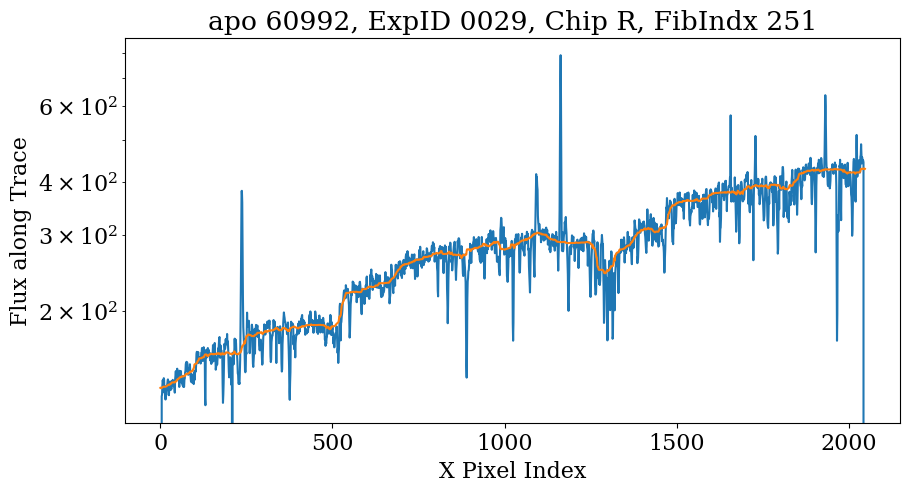

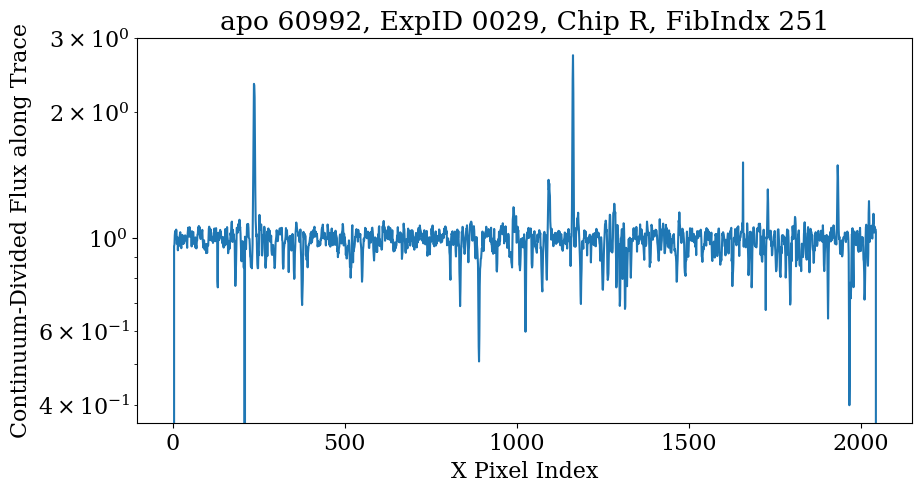

In [143]:
plt.figure(figsize=(10,5))
plt.gca().set_yscale('log')
plt.title(f'{tele} {mjd}, ExpID {expid}, Chip {chip}, FibIndx {chosen_fib_ind}')
plt.plot(x_inds,pixel_best_fit_fluxes)
plt.plot(x_inds,med_cont)
plt.xlabel('X Pixel Index')
plt.ylabel('Flux along Trace')
plt.show()

plt.figure(figsize=(10,5))
plt.gca().set_yscale('log')
plt.title(f'{tele} {mjd}, ExpID {expid}, Chip {chip}, FibIndx {chosen_fib_ind}')
plt.plot(x_inds,pixel_best_fit_fluxes/med_cont)
plt.xlabel('X Pixel Index')
plt.ylabel('Continuum-Divided Flux along Trace')
plt.show()


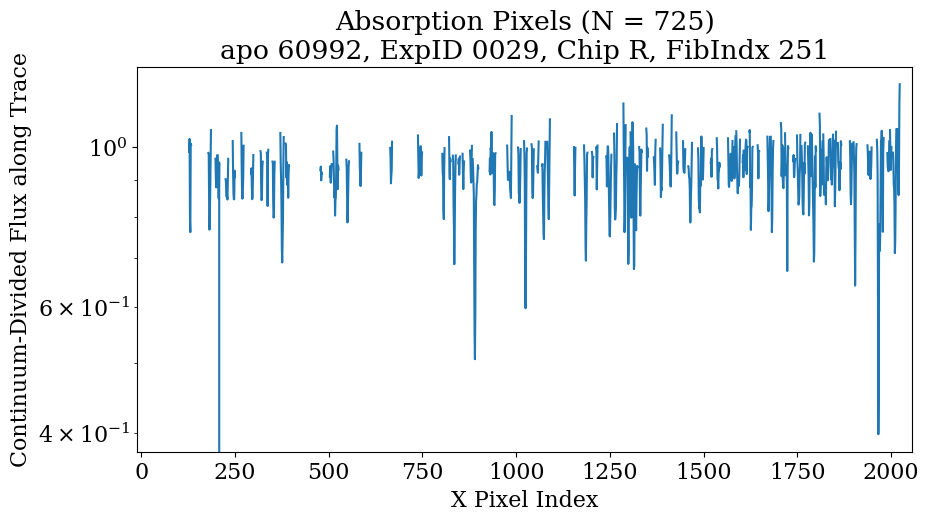

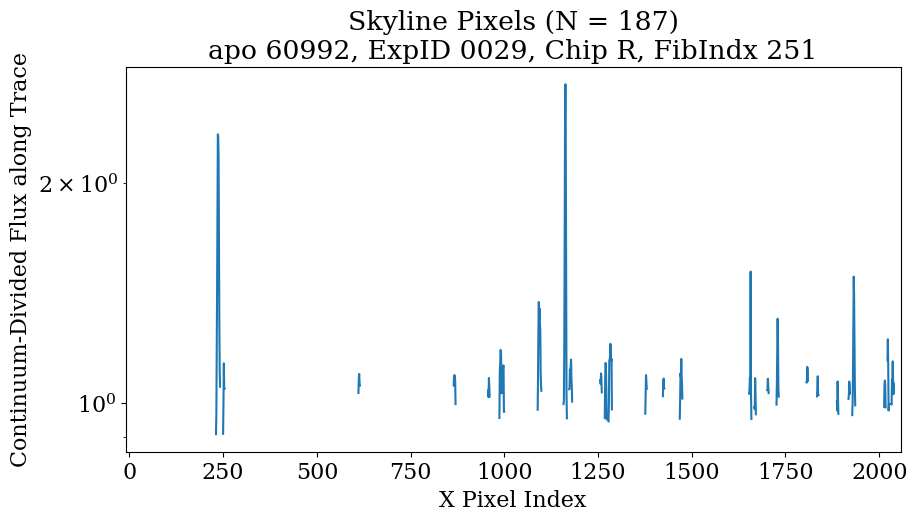

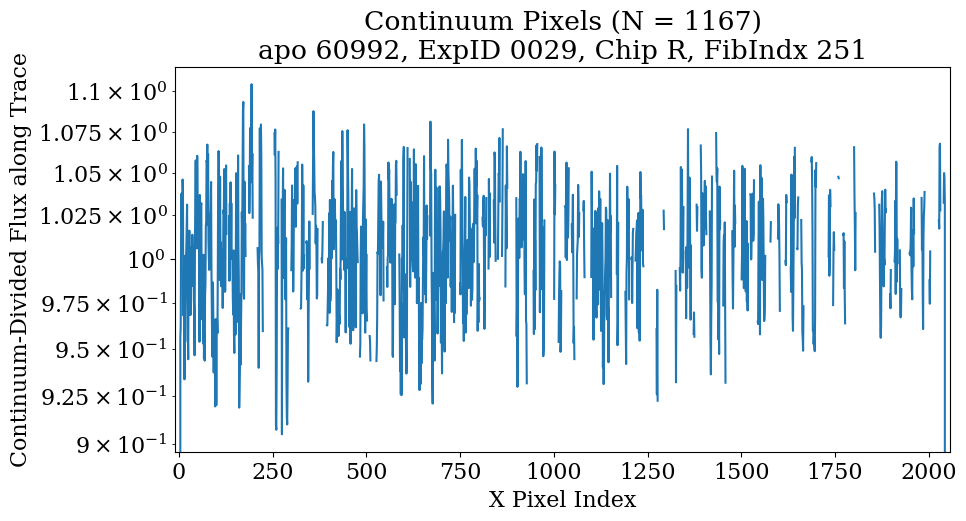

In [144]:
absorption_pixels = (cont_resid_sigmas < -10) & (pixel_best_fit_fluxes/med_cont < 0.95)
for pix_ind in np.where(absorption_pixels)[0]:
    absorption_pixels[np.abs(x_inds-pix_ind) < 3] = True
absorption_pixels = absorption_pixels & np.isfinite(pixel_best_fit_fluxes)
skyline_pixels = (cont_resid_sigmas > 10) & (~absorption_pixels) & (pixel_best_fit_fluxes/med_cont > 1.05)
for pix_ind in np.where(skyline_pixels)[0]:
    skyline_pixels[np.abs(x_inds-pix_ind) < 3] = True
skyline_pixels = skyline_pixels & np.isfinite(pixel_best_fit_fluxes)

continuum_pixels = np.isfinite(pixel_best_fit_fluxes) & (~absorption_pixels) & (~skyline_pixels)


absorption_plot_flux = np.zeros(len(pixel_best_fit_fluxes))*np.nan
absorption_plot_flux[absorption_pixels] = (pixel_best_fit_fluxes/med_cont)[absorption_pixels]
skyline_plot_flux = np.zeros(len(pixel_best_fit_fluxes))*np.nan
skyline_plot_flux[skyline_pixels] = (pixel_best_fit_fluxes/med_cont)[skyline_pixels]
continuum_plot_flux = np.zeros(len(pixel_best_fit_fluxes))*np.nan
continuum_plot_flux[continuum_pixels] = (pixel_best_fit_fluxes/med_cont)[continuum_pixels]

plt.figure(figsize=(10,5))
plt.gca().set_yscale('log')
plt.title(f'Absorption Pixels (N = {np.sum(absorption_pixels)})\n{tele} {mjd}, ExpID {expid}, Chip {chip}, FibIndx {chosen_fib_ind}')
plt.plot(x_inds,absorption_plot_flux)
plt.xlabel('X Pixel Index')
plt.ylabel('Continuum-Divided Flux along Trace')
plt.xlim(x_inds[0]-10,x_inds[-1]+10)
plt.show()

plt.figure(figsize=(10,5))
plt.gca().set_yscale('log')
plt.title(f'Skyline Pixels (N = {np.sum(skyline_pixels)})\n{tele} {mjd}, ExpID {expid}, Chip {chip}, FibIndx {chosen_fib_ind}')
plt.plot(x_inds,skyline_plot_flux)
plt.xlabel('X Pixel Index')
plt.ylabel('Continuum-Divided Flux along Trace')
plt.xlim(x_inds[0]-10,x_inds[-1]+10)
plt.show()

plt.figure(figsize=(10,5))
plt.gca().set_yscale('log')
plt.title(f'Continuum Pixels (N = {np.sum(continuum_pixels)})\n{tele} {mjd}, ExpID {expid}, Chip {chip}, FibIndx {chosen_fib_ind}')
plt.plot(x_inds,continuum_plot_flux)
plt.xlabel('X Pixel Index')
plt.ylabel('Continuum-Divided Flux along Trace')
plt.xlim(x_inds[0]-10,x_inds[-1]+10)
plt.show()


In [145]:
np.all(np.isfinite(data_cube)),np.all(np.isfinite(read_errs))

(True, True)

In [146]:
np.where(skyline_pixels)[0]

array([ 231,  232,  233,  234,  235,  236,  237,  238,  239,  240,  241,
        242,  250,  251,  252,  253,  254,  611,  612,  613,  614,  615,
        865,  866,  867,  868,  869,  870,  957,  958,  959,  960,  961,
        987,  988,  989,  990,  991,  992,  993,  994,  995,  996,  997,
        998,  999, 1000, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1096,
       1097, 1098, 1099, 1158, 1159, 1160, 1161, 1162, 1163, 1164, 1165,
       1166, 1167, 1173, 1174, 1175, 1176, 1177, 1178, 1179, 1180, 1181,
       1256, 1257, 1258, 1259, 1260, 1268, 1269, 1270, 1271, 1272, 1273,
       1278, 1279, 1280, 1281, 1282, 1283, 1284, 1285, 1286, 1287, 1376,
       1377, 1378, 1379, 1380, 1423, 1424, 1425, 1426, 1427, 1468, 1469,
       1470, 1471, 1472, 1473, 1474, 1475, 1653, 1654, 1655, 1656, 1657,
       1658, 1659, 1667, 1668, 1669, 1670, 1671, 1701, 1702, 1703, 1704,
       1705, 1726, 1727, 1728, 1729, 1730, 1731, 1732, 1806, 1807, 1808,
       1809, 1810, 1834, 1835, 1836, 1837, 1838, 18

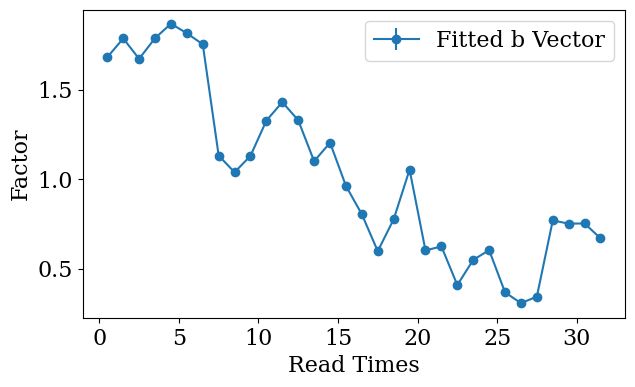

In [147]:
use_pixel_inds = np.where(absorption_pixels)[0]
use_pixel_inds = np.where(continuum_pixels)[0]
use_pixel_inds = np.where(skyline_pixels)[0]

data_per_pix = pixel_raw_data.T * pixel_gainMat[:,None] #convert to electrons
read_error_per_pix = np.sqrt(pixel_readVarMat)
n_reads = data_3d['outdat'].shape[0]


np.random.seed(123)
use_pixels = np.random.choice(np.where(continuum_pixels)[0],100,replace=False)

n_pixels = len(use_pixels)
data_cube = data_per_pix[use_pixels]

count_diffs = np.diff(data_cube,axis=1)


obs_fluxes = np.copy(data_cube)
read_errs = read_error_per_pix[use_pixels]

max_b_ind,b_vect_mean,b_vect_Vinv,b_vect_V,\
        f_max_means_given_b,f_max_ivars_given_b,\
        comb_param_means,comb_param_Vinv,comb_param_V = fit_flux.measure_time_dep_fluxes_LINEAR(obs_fluxes,read_errs,
                                                       n_max_repeat=1000,b_vect_change_tol=1e-10,
                                                       min_b_val=1e-10,min_f_val=1e-10)

f_means_no_b,f_ivars_no_b,chi2s_data_no_b = fit_flux.fit_fluxes_optimal(obs_fluxes,read_errs,
                                                                           n_repeat=2,b_vect=None)
f_means_with_b,f_ivars_with_b,chi2s_data_with_b = fit_flux.fit_fluxes_optimal(obs_fluxes,read_errs,
                                                                           n_repeat=2,b_vect=b_vect_mean)

non_max_inds = np.ones(len(b_vect_mean)).astype(bool)
non_max_inds[max_b_ind] = False
non_max_inds = np.where(non_max_inds)[0]

b_vect_errs = np.sqrt(np.diag(b_vect_V))
f_max_errs_given_b = np.power(f_max_ivars_given_b,-0.5)

b_vect_mean_linear = np.copy(b_vect_mean)
b_vect_errs_linear = np.copy(b_vect_errs)
b_vect_cov_linear = np.copy(b_vect_V)
f_max_means = comb_param_means[:n_pixels]


#rescaling average
 
f_max_post = np.copy(f_max_means)
b_vect_post = np.copy(b_vect_mean_linear)
b_vect_post_cov = np.copy(b_vect_cov_linear)
curr_f_post_guess = f_max_post[:, None] * b_vect_post[None, :]
read_times = np.arange(n_reads)
obs_flux_diffs = np.diff(obs_fluxes,axis=1)
read_vars = np.power(read_errs,2)

plt.figure(figsize=(7, 4))
plt.errorbar(read_times[:-1]+0.5,b_vect_post/np.nanmedian(b_vect_post),yerr=np.sqrt(np.diag(b_vect_post_cov/np.nanmedian(b_vect_post))),label= "Fitted b Vector",fmt = "-o")


plt.ylabel("Factor")
plt.xlabel("Read Times")  
plt.legend()
plt.show()



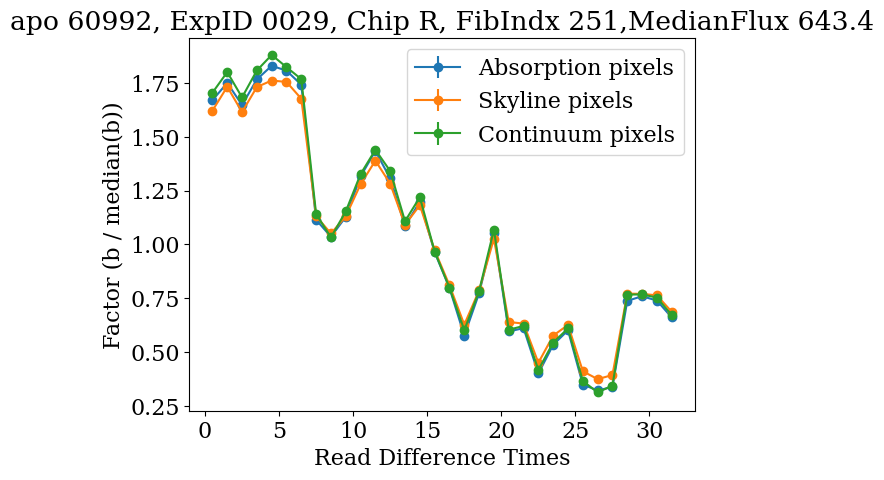

In [148]:
# Assume you already have:
# pixel_raw_data, pixel_gainMat, pixel_readVarMat, data_3d
# absorption_pixels, skyline_pixels, continuum_pixels
# and fit_flux imported

# --- Precompute shared stuff ---
data_per_pix = pixel_raw_data.T * pixel_gainMat[:, None]  # convert to electrons
read_error_per_pix = np.sqrt(pixel_readVarMat)
n_reads = data_3d['outdat'].shape[0]
read_times = np.arange(n_reads)

# Define the three pixel sets
pixel_sets = {
    "Absorption pixels": np.where(absorption_pixels)[0],
    "Skyline pixels":    np.where(skyline_pixels)[0],
    "Continuum pixels":  np.where(continuum_pixels)[0],
}


#plt.figure(figsize=(7, 4))

for label, use_pixel_inds in pixel_sets.items():
    # Skip if this mask is empty
    if len(use_pixel_inds) == 0:
        continue

    if label == "Skyline pixels":
        n_select = 50
    else:
        n_select = 50
        
    # Pick up to 100 random pixels from this set
    np.random.seed(123)
    use_pixels = np.random.choice(use_pixel_inds, n_select, replace=False)

    n_pixels = len(use_pixels)
    obs_fluxes = data_per_pix[use_pixels]
    read_errs = read_error_per_pix[use_pixels]
    obs_flux_diffs = np.diff(obs_fluxes,axis=1)
    # --- Run your fits for this pixel class ---
    max_b_ind, b_vect_mean, b_vect_Vinv, b_vect_V, \
        f_max_means_given_b, f_max_ivars_given_b, \
        comb_param_means, comb_param_Vinv, comb_param_V = \
        fit_flux.measure_time_dep_fluxes_LINEAR(
            obs_fluxes, read_errs,
            n_max_repeat=1000,
            b_vect_change_tol=1e-10,
            min_b_val=1e-10,
            min_f_val=1e-10
        )

    # Posterior summaries
    b_vect_post = np.copy(b_vect_mean)
    b_vect_post_cov = np.copy(b_vect_V)

    # Normalization + error bars
    scale = np.nanmedian(b_vect_post)
    b_norm = b_vect_post / scale
    b_err_norm = np.sqrt(np.diag(b_vect_post_cov)) / scale

    # --- Plot this set on the same axes ---
    plt.errorbar(
        read_times[:-1] + 0.5,
        b_norm,
        yerr=b_err_norm,
        fmt='-o',
        label=label
    )

plt.ylabel("Factor (b / median(b))")
plt.xlabel("Read Difference Times")
plt.legend()
plt.tight_layout()
plt.title(f'{tele} {mjd}, ExpID {expid}, Chip {chip}, FibIndx {chosen_fib_ind},MedianFlux {np.round(fiber_med_fluxes[chosen_fib_ind],2)}')
plt.show()


163.0147851662585